# Modèlisation statistique des séries temporelles

Nous allons explorer une famille de modèles linéaires utilisés pour décrire et prévoir des séries temporelles.

1. Modèles autorégressifs **AR(p)**
2. Modèles à moyenne mobile **MA(q)**
3. Modèles mixtes **ARMA(p,q)**
4. Modèles avec intégration **ARIMA(p,d,q)**
5. Modèles saisonniers **SARIMA(p,d,q)(P,D,Q)m**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

## 1. Modèles auto-régressifs **AR(p)**

Comme supposé par le nom, les modèles auto-régressifs sont des modèles qui "se régressent sur eux-mêmes", ça peut paraître un peu abscon mais cela veut dire que l'on prend en compte le fait que **la valeur future d'une série temporelle dépend d'une ou de plusieurs de ses valeurs passées**. 

Pour ces modèles on prend donc l'hypothèse assez légitime que le passé influence le futur. Jusqu'à quel point ? C'est l'**ordre** (noté p) d'un modèle auto-régressif qui le paramétrise. On note ainsi : 

> Vue symbolique

$$
X_t = \phi_0 + \sum_{i=1}^p \phi_i X_{t-i} + \varepsilon_t
$$

où :
  - $\phi_i$ : coefficients que l'on apprend grâce aux données 
  - $\varepsilon_t$ : bruit aléatoire supposé gaussien.

Un peu comme dans une régression linéaire, on régresse $X_t$ sur ses valeurs passées (ou *lags* en anglais). 

> Vue schématique pour un AR(1)

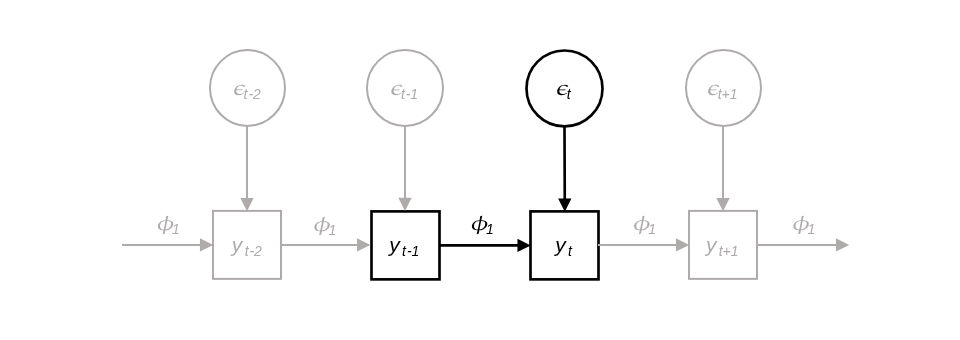

> Vue schématique pour un AR(2)

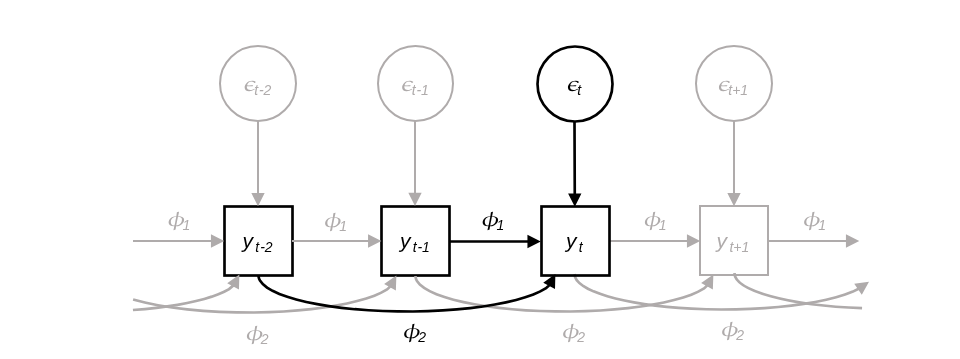

> Exemple

Supposez que l'on veuille modéliser la consommation de sucre d'un individu dans le temps. Le sucre étant addictif, il est raisonnable de penser qu'une consommation passée crée une dépendance et influe sur les consommations futures (*inertie*).

Si l'on postule que la consommation d'hier et avant-hier influent sur la consommation d'aujourd'hui on pourrait écrire : 

$$
Conso_{ajdh} = \phi_0 + \phi_1 Conso_{hier} + \phi_2 Conso_{avant_hier} + \varepsilon_t
$$

### 1.1. A quoi ressemblent des processus auto-régressifs ?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def simulate_ar_p(betas, n=200, sigma=1, burn_in=100):
    """
    sigma : écart type du bruit gaussien
    burn_in : nombre de pas laissés pour que le processus atteigne son régime stationnaire
    """
    np.random.seed(42)
    p = len(betas)
    x = np.zeros(n + burn_in)
    epsilon = np.random.normal(0, sigma, n + burn_in)
    for t in range(p, n + burn_in):
        x[t] = np.dot(betas, x[t-p:t][::-1]) + epsilon[t]
    # ne renvoie que les valeurs post atteinte du régime stationnaire
    return x[burn_in:]

# Plot AR process
def plot_ar(**betas_dict):
    # betas_dict has keys like 'betas0', 'betas1', ...
    betas = [v for k, v in sorted(betas_dict.items())]
    data = simulate_ar_p(betas)

    equation = " + ".join(
        [fr"{b:.1f} X_{{t-{i+1}}}" for i, b in enumerate(betas)]
    )

    plt.figure(figsize=(10, 4))
    plt.plot(data, label=f'AR({len(betas)}) process')

    plt.title(
        fr"AR({len(betas)}) simulation"
        "\n"
        fr"$X_t = {equation} + \epsilon_t$"
    )
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Create sliders dynamically
def create_ar_widgets(order):
    sliders = {}
    for i in range(order):
        sliders[f'betas{i}'] = widgets.FloatSlider(
            value=0.0,
            min=-2,
            max=2,
            step=0.1,
            description=f'betas{i+1}:'
        )
    return sliders

# Dropdown to select AR order
order_selector = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    description='AR order p:'
)

output = widgets.Output()

def update_sliders(change):
    with output:
        clear_output(wait=True)
        sliders = create_ar_widgets(order_selector.value)
        ui = widgets.VBox(list(sliders.values()))
        interactive_plot = widgets.interactive_output(plot_ar, sliders)
        display(ui, interactive_plot)

# Initial display
update_sliders(None)

# Observe changes in AR order
order_selector.observe(update_sliders, names='value')

display(order_selector, output)


IntSlider(value=1, description='AR order p:', max=10, min=1)

Output()

### 1.2. PACF et ACF des processus AR(p)

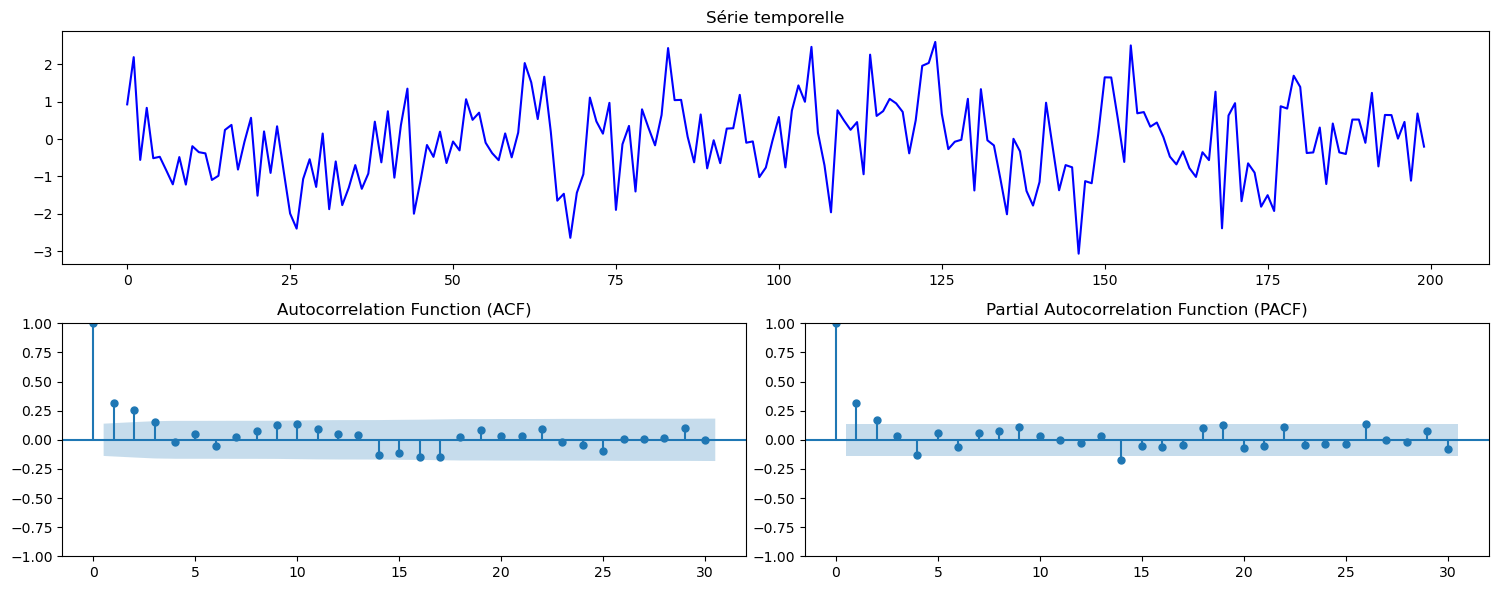

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_ts_acf_pacf(data, lags=40):
    fig = plt.figure(figsize=(15, 6))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

    ax_ts = fig.add_subplot(gs[0, :])
    ax_ts.plot(data, color='blue')
    ax_ts.set_title("Série temporelle")

    ax_acf = fig.add_subplot(gs[1, 0])
    plot_acf(data, lags=lags, ax=ax_acf)
    ax_acf.set_title("Autocorrelation Function (ACF)")

    ax_pacf = fig.add_subplot(gs[1, 1])
    plot_pacf(data, lags=lags, ax=ax_pacf)
    ax_pacf.set_title("Partial Autocorrelation Function (PACF)")

    plt.tight_layout()
    plt.show()

from statsmodels.tsa.arima_process import ArmaProcess
phis = np.array([0.3, 0.2])
ar_params = np.r_[1, -phis]  # statsmodels uses the sign convention

ts = ArmaProcess(ar=ar_params).generate_sample(nsample=200)
plot_ts_acf_pacf(ts, lags=30)

### 1.3. Une propriété intéressante 

Si la somme des coefficients $\phi_i$ est supérieure à 1, le processus est dit *explosif*, c'est à dire que les valeurs de la série temporelle vont tendre vers l'infini.

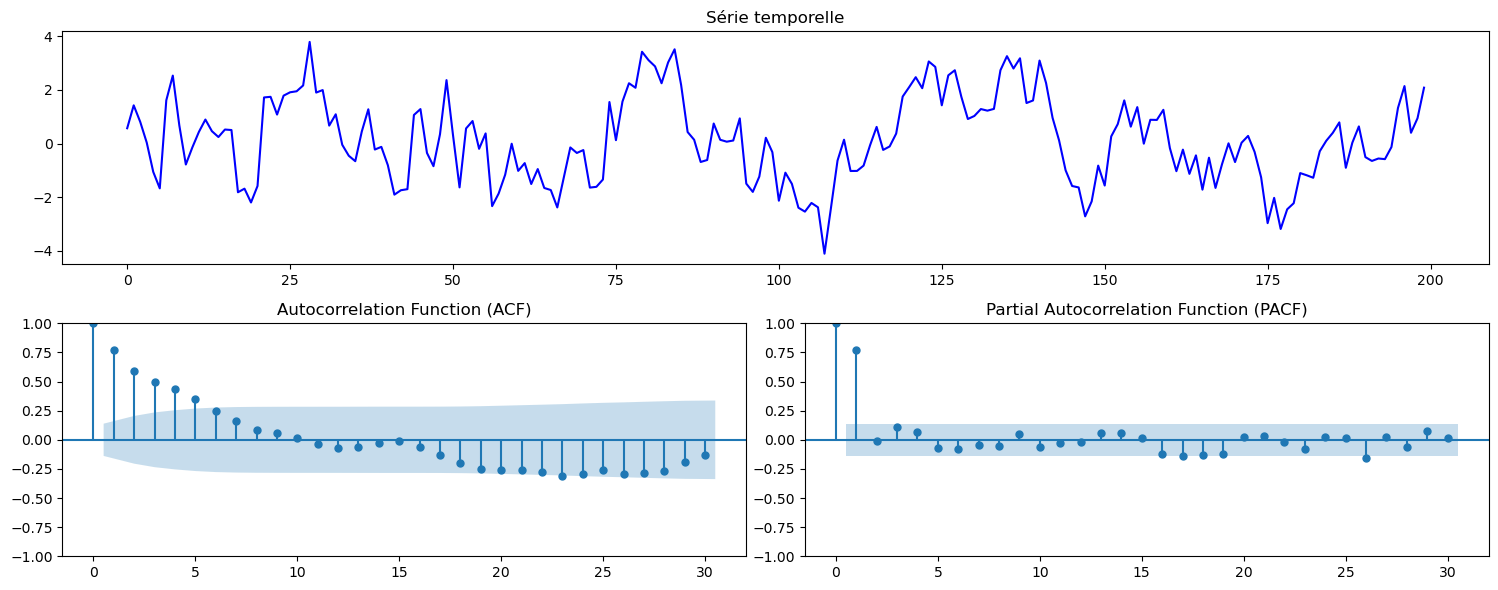

In [21]:
phis = np.array([0.8])
ar_params = np.r_[1, -phis]  # statsmodels uses the sign convention

ts = ArmaProcess(ar=ar_params).generate_sample(nsample=200)
plot_ts_acf_pacf(ts, lags=30)

In [11]:
from statsmodels.tsa.stattools import adfuller


adfuller(ts)

(np.float64(3.6007118436365228e+16),
 1.0,
 7,
 192,
 {'1%': np.float64(-3.4648754262570978),
  '5%': np.float64(-2.876714157488788),
  '10%': np.float64(-2.574858699001736)},
 np.float64(3316.268015917157))

## 2. Modèles à moyenne mobile **MA(q)**


Ici, les postulations sont un peu différentes. On suppose que la valeur future d'une série temporelle dépend des **erreurs passées** (ou *shocks* en anglais), c'est à dire de perturbations aléatoires qui ont affecté la série dans le passé.

> Exemple

Le sucre, ça apporte du réconfort ... Imaginons qu'un individu ait eu une mauvaise journée (perturbation aléatoire négative) et qu'il se soit consolé en mangeant du sucre. Sa consommation de sucre aujourd'hui sera donc influencée par cette perturbation passée. A contrario, une bonne journée (perturbation aléatoire positive) pourrait réduire sa consommation de sucre.

On écrirait alors :

$$
Conso_{ajdh} = \theta_0 + \varepsilon_{ajdh} + \theta_1 \varepsilon_{hier} + \theta_2 \varepsilon_{avant_hier}
$$

où $\varepsilon_t$ représente la perturbation aléatoire à l'instant t (bonne ou mauvaise journée).

> Vue schématique pour un MA(1)

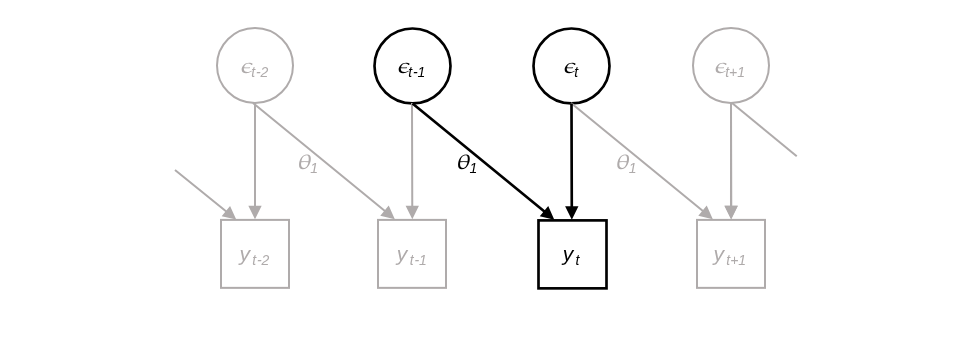


> Vue schématique pour un MA(2)

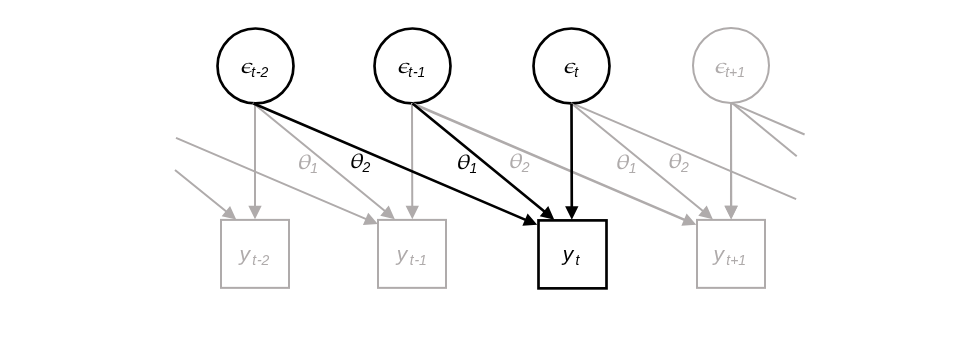

> Vue symbolique

Formellement, on écrit un modèle à moyenne mobile d'ordre q (MA(q)) comme suit :

$$
X_t = \theta_0 + \varepsilon_t + \sum_{i=1}^q \theta_i \varepsilon_{t-i}
$$ 




### 2.1. A quoi ressemblent des processus à moyenne mobile ?

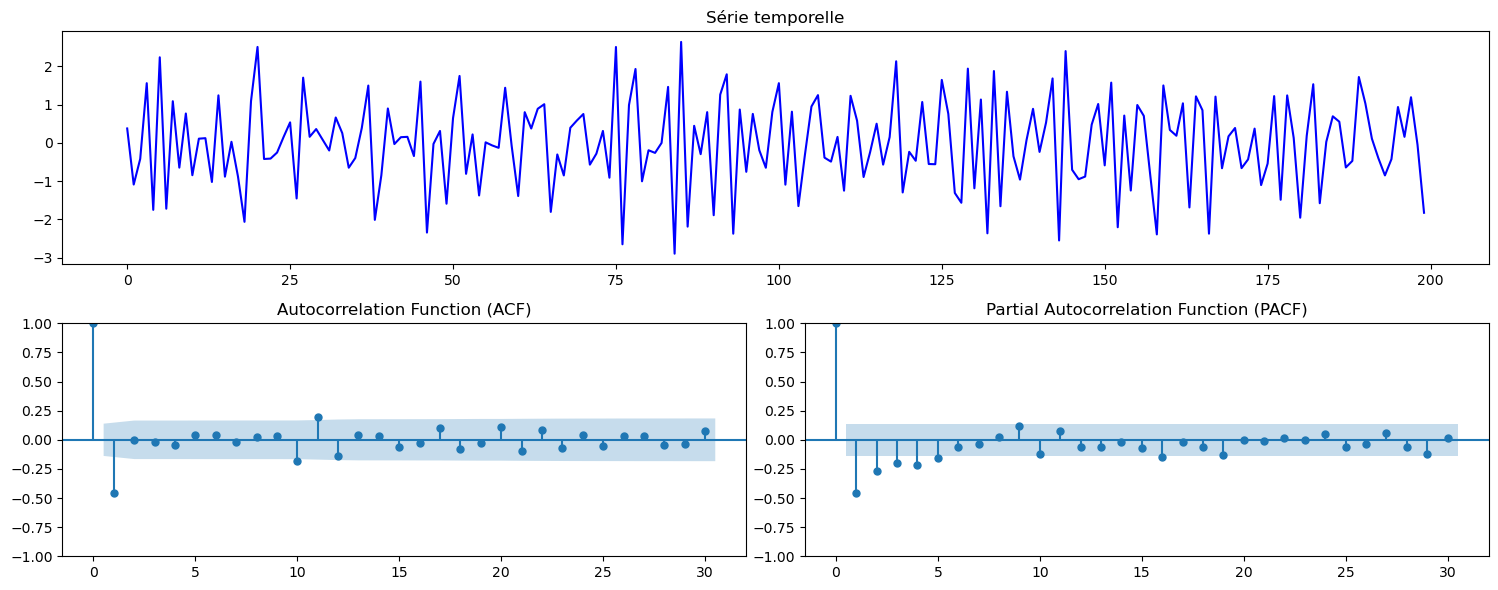

In [14]:
from statsmodels.tsa.arima_process import ArmaProcess
thetas = np.array([0.5])
ma_params = np.r_[1, -thetas]  # statsmodels uses the sign convention

ts = ArmaProcess(ma=ma_params).generate_sample(nsample=200)
plot_ts_acf_pacf(ts, lags=30)

### 2.2. ACF et PACF des processus MA(q)

## 3. Modèles mixtes **ARMA(p,q)**


Ce modèle combine les deux approches précédentes. On suppose que la valeur future d'une série temporelle dépend à la fois de ses valeurs passées et des erreurs passées. 

> Exemple

On peut supposer que la consommation de sucre d'un individu dépend à la fois de ses consommations passées (addiction) et des perturbations aléatoires (bonne ou mauvaise journée).

On écrirait alors :

$$
Conso_{ajdh} = \phi_0 + \phi_1 Conso_{hier} + \phi_2 Conso_{avant_hier} + \varepsilon_{ajdh} + \theta_1 \varepsilon_{hier} + \theta_2 \varepsilon_{avant_hier}
$$

> Vue schématique d'un ARMA(1, 1)

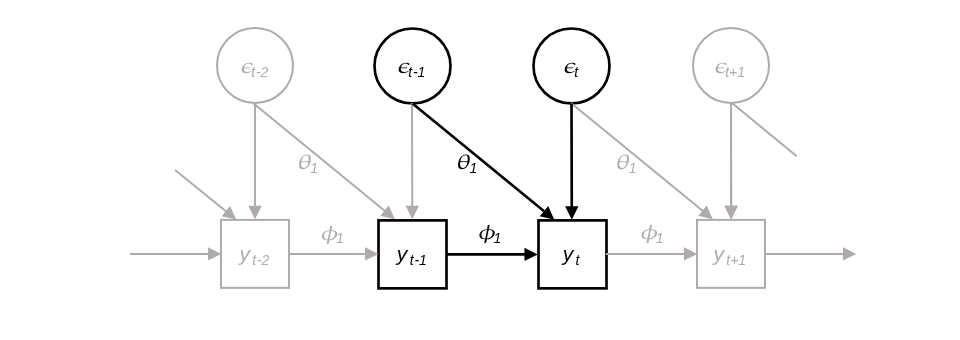

> Vue symbolique

Formellement, on écrit un modèle mixte d'ordre (p,q) (ARMA(p,q)) comme suit :

$$
X_t = \phi_0 + \sum_{i=1}^p \phi_i X_{t-i} + \varepsilon_t + \sum_{j=1}^q \theta_j \varepsilon_{t-j}
$$

### 3.1. Visualisation des processus ARMA(p,q)

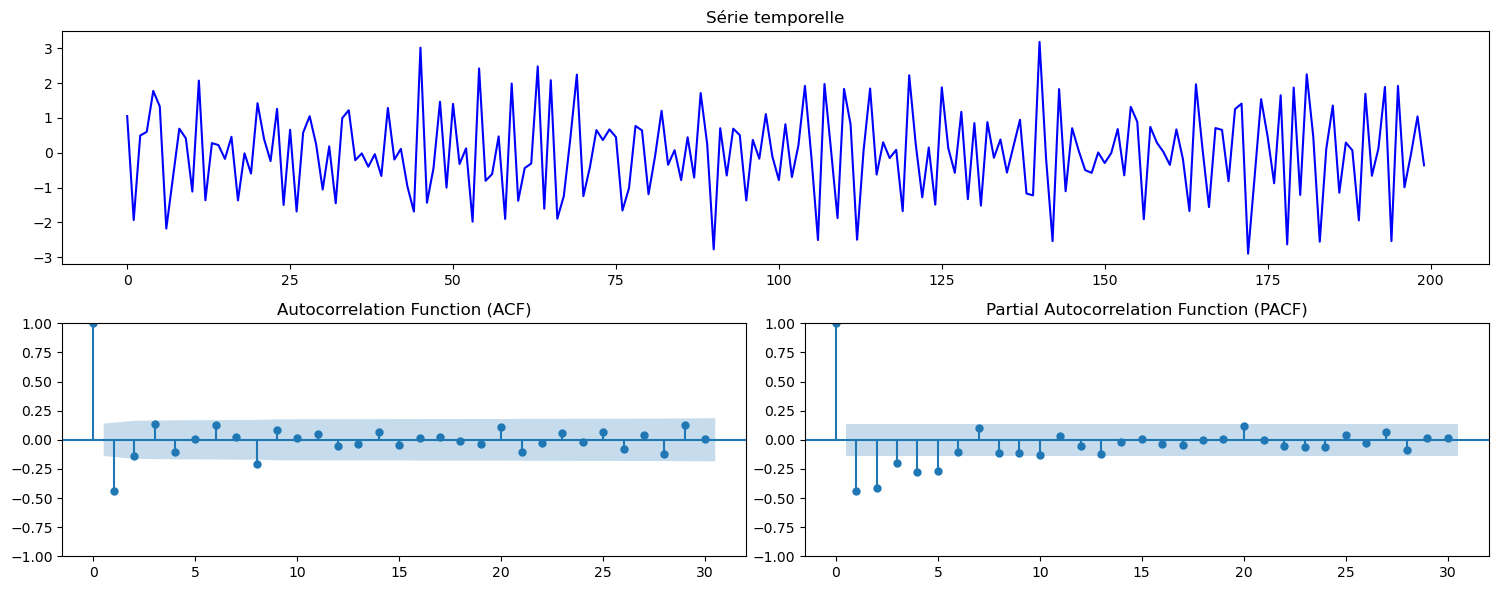

In [15]:
thetas = np.array([0.9])
ma_params = np.r_[1, -thetas]  # statsmodels uses the sign convention

phis = np.array([0.01])
ar_params = np.r_[1, -phis]  # statsmodels uses the sign convention

ts = ArmaProcess(ma=ma_params, ar=ar_params).generate_sample(nsample=200)
plot_ts_acf_pacf(ts, lags=30)

### 3.2. ACF et PACF des processus ARMA(p,q)

## 4. Modèles avec intégration **ARIMA(p,d,q)**

Pour tous les modèles précédents, on a fait l'hypothèse que la série temporelle était stationnaire : la relation entre les valeurs passées et futures ne changent pas dans le temps (les $\phi$ restent les mêmes dans un modèle AR) de même que les $\theta$ dans un modèle MA.

Cependant, de nombreuses séries temporelles réelles ne sont pas stationnaires. Par exemple, une série temporelle peut présenter une tendance (augmentation ou diminution à long terme) ou une saisonnalité (variations périodiques).

C'est là qu'interviennent les modèles ARIMA (AutoRegressive Integrated Moving Average). Le terme "Integrated" fait référence à la différenciation de la série temporelle pour la rendre stationnaire avant d'appliquer les composantes AR et MA.

### 4.1. Différenciation d'une série temporelle

Partons d'une série non stationnaire : le cours de bourse de Google chaque jour à la fermeture des marchés.

[*********************100%***********************]  1 of 1 completed


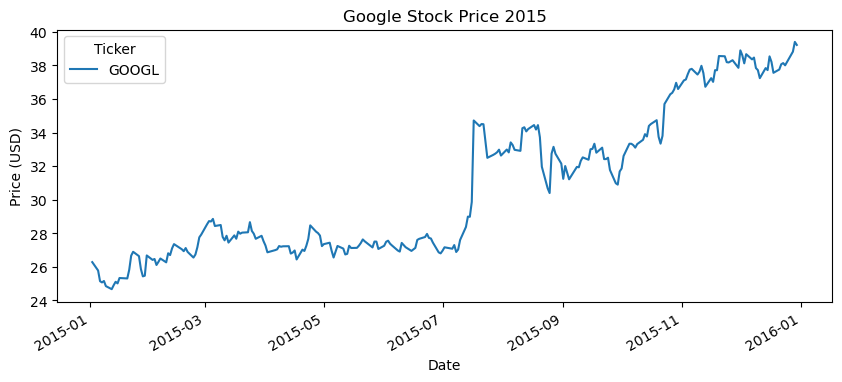

In [16]:
# google stock price 201
import yfinance as yf
import pandas as pd

ts = yf.download("GOOGL", start="2015-01-01", end="2015-12-31", auto_adjust=True)["Close"]

ts.plot(title="Google Stock Price 2015", figsize=(10, 4))
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show();

Cette série n'est clairement pas stationnaire, on peut s'en convaincre avec un test ADF (Augmented Dickey-Fuller), nous y reviendrons plus tard.

In [17]:
# adf test 
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.5969367766856857
p-value: 0.8716726886162494


Cette non-stationnarité s'exprime aussi dans les corrélogrammes : l'acf décroit lentement au fur et à mesure des lags, sans jamais atteindre 0. 

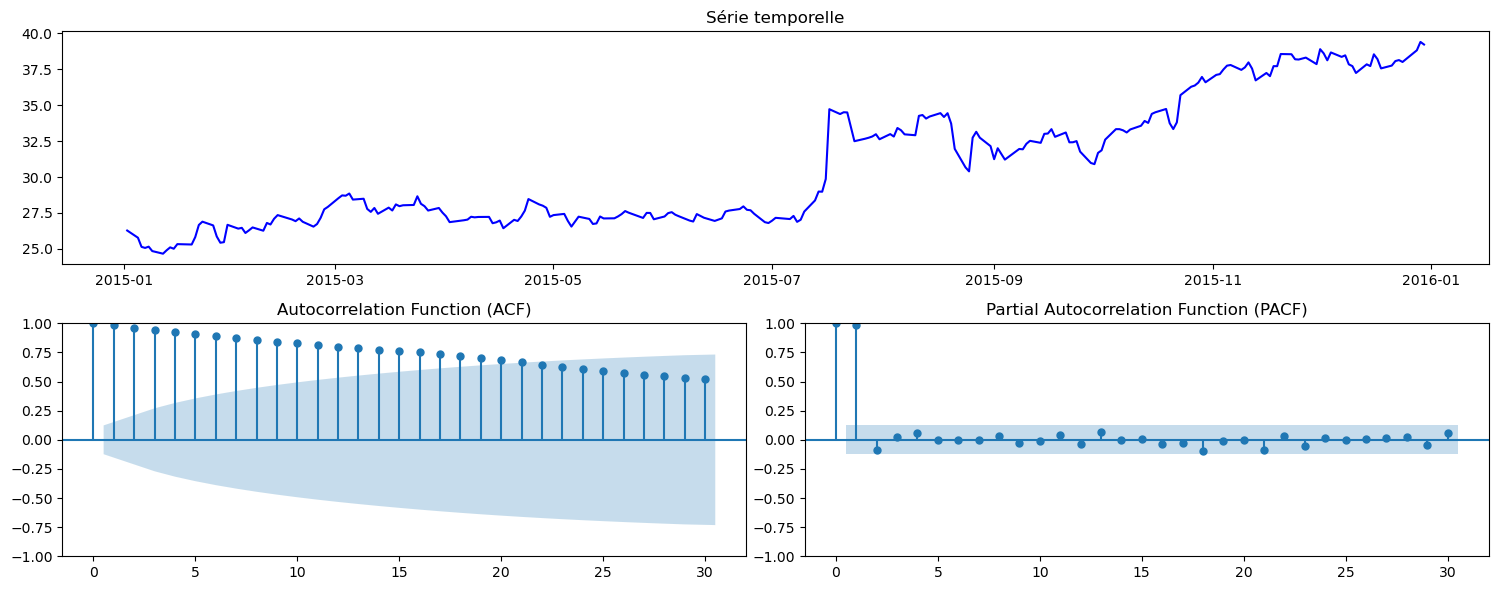

In [18]:
plot_ts_acf_pacf(ts, lags=30)

Une manière de rendre la série stationnaire est de la différencier, c'est à dire de soustraire à chaque valeur de la série la valeur précédente. On regarde ainsi le changement entre deux instants consécutifs.

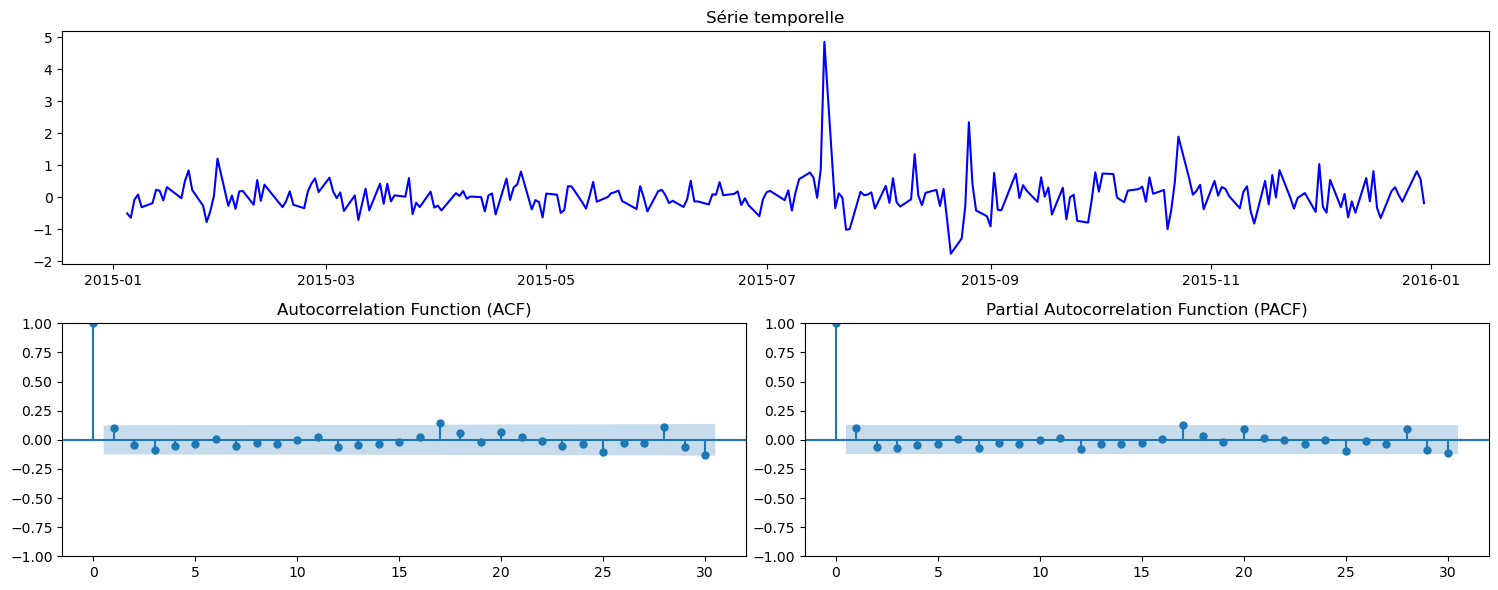

In [19]:
ts_diff = ts.diff().dropna()

plot_ts_acf_pacf(ts_diff, lags=30)

On peut vérifier que la série est bien stationnaire

In [20]:
results = adfuller(ts_diff)
print('ADF Statistic:', results[0])
print('p-value:', results[1])

ADF Statistic: -14.165793256879635
p-value: 2.043464049523482e-26


### 4.2. L'opérateur de lag et de différenciation

Pour pouvoir vous donner la représentation symbolique des modèles ARIMA, il nous faut introduire deux opérateurs très utiles en séries temporelles : l'opérateur de lag et l'opérateur de différenciation.

L'opérateur de lag (noté L) est défini comme suit :
$$
\begin{aligned}
L X_t &= X_{t-1} \\
L^2 X_t &= X_{t-2} \\
\ldots
\end{aligned}
$$


L'opérateur de différenciation (noté Δ) est défini comme suit :

$$
\begin{aligned}
\Delta X_t &= X_t - X_{t-1} = (1 - L) X_t \\
\Delta^2 X_t &= \Delta(\Delta X_t) = (1 - L)^2 X_t \\
\ldots
\end{aligned}
$$

Ainsi un AR(p) peut s'écrire comme suit avec l'opérateur de lag :
$$
(1 - \phi_1 L - \phi_2 L^2 - ... - \phi_p L^p) X_t = \varepsilon_t
$$

et un MA(q) comme suit :
$$
X_t = (1 + \theta_1 L + \theta_2 L^2 + ... + \theta_q L^q) \varepsilon_t
$$

### 4.3. Modélisation ARIMA

Un modèle ARIMA(p, d, q) s'écrit de la manière suivante : 

$$
\phi(L) (1 - L)^d X_t = \theta(L) \varepsilon_t
$$

où : 
- p : ordre de la partie auto-régressive
- d : ordre de différenciation
- q : ordre de la partie moyenne mobile

Très souvent, le paramètre d est égal à 1, ce qui signifie que l'on différencie la série une seule fois pour la rendre stationnaire avant d'appliquer les composantes AR et MA.

Une autre manière de voir un modèle ARIMA(p,d,q) est de considérer qu'il s'agit d'un modèle ARMA(p,q) appliqué à une série différenciée d'ordre d.

## 5. Modèles saisonniers **SARIMA(p,d,q)(P,D,Q)m**

Un autre caractéristique fréquente des séries temporelles est la saisonnalité, c'est à dire des variations périodiques qui se répètent à intervalles réguliers (par exemple, les ventes de glaces augmentent chaque été).

Pour capturer cette saisonnalité, on utilise des modèles SARIMA (Seasonal ARIMA) qui étendent les modèles ARIMA en incluant des composantes saisonnières.

Un modèle SARIMA(p,d,q)(P,D,Q)m s'écrit de la manière suivante :
$$
\phi(L) \Phi(L^m) (1 - L)^d (1 - L^m)^D X_t = \theta(L) \Theta(L^m) \varepsilon_t
$$
où :
- (p,d,q) : paramètres non saisonniers (comme dans ARIMA)
- (P,D,Q) : paramètres saisonniers
- m : période de la saisonnalité (par exemple, m=12 pour des données mensuelles avec une saisonnalité annuelle ou m=4 pour des données trimestrielles avec une saisonnalité annuelle ...)

## 6. Trouver le modèle à partir d'un corrélogramme et d'un PACF
![guess](./guess_with_acf.png)

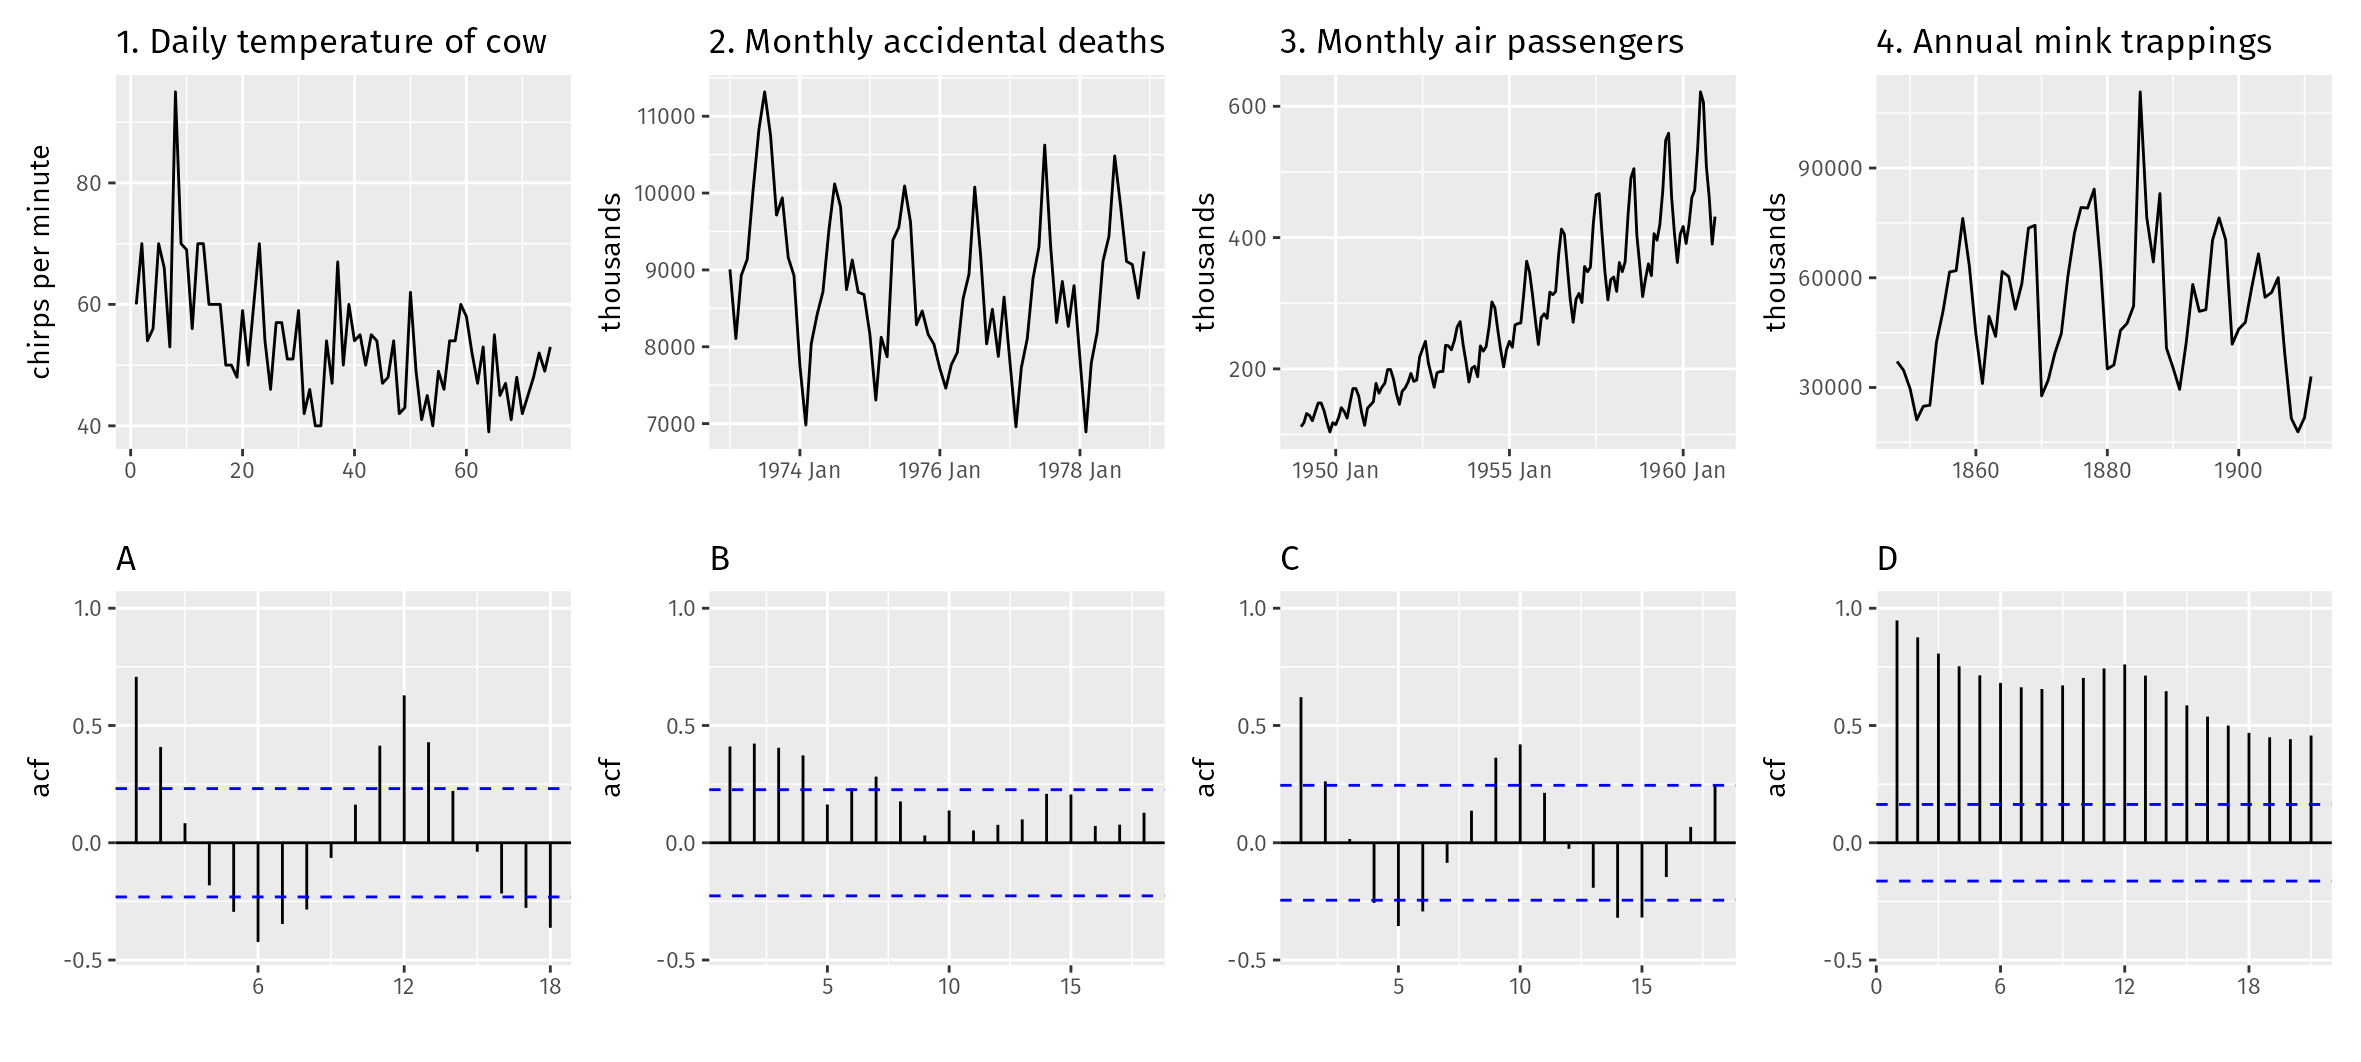

## 7. Modélisation en pratique : la méthodologie Box-Jenkins

Tout ceci est bien beau mais comment fait-on en pratique pour modéliser une série temporelle ? 



### Références 

- Les vues schématiques sont inspirées de [ce blog](https://matilda.fss.uu.nl/articles/moving-average-model.html) pour les MA. Les autres vues ont été générées par NanoBanana.